In [4]:
%matplotlib notebook

''' Input style
into:0/1,is_reflect:0/1,p:x y z,in:x y z,dir:x y z,normal:x y z

'''

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class float3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    # +
    def __iadd__(self, other):
        return float3(self.x + other.x, self.y + other.y, self.z + other.z)
    def __add__(self, other):
        return float3(self.x + other.x, self.y + other.y, self.z + other.z)
    
    # -
    def __sub__(self, other):
        return float3(self.x - other.x, self.y - other.y, self.z - other.z)
    def __isub__(self, other):
        return float3(self.x - other.x, self.y - other.y, self.z - other.z)
    
    # *
    def __mul__(self, t):
        return float3(self.x*t, self.y*t, self.z*t)
    
    # /
    def __truediv__(self, t):
        if t == 0:
            return self
        else:
            return self * (1/t)
    def length_squared(self):
        return self.x*self.x + self.y*self.y + self.z*self.z
        
    def length(self):
        return math.sqrt(self.length_squared())
    
    def __str__(self):
        return '{} {} {}'.format(self.x, self.y, self.z)
    
def dot(v1, v2):
    return v1.x*v2.x + v1.y*v2.y + v1.z*v2.z

def normalize(v):
    return v / v.length()

def extract_intersect_config(line):
    '''
    config (string)
    '''
    elems = line.split(',')
    config = dict()
    
    bool_names = ['into', 'is_reflect']
    float3_names = ['p', 'p0', 'p1', 'p2', 'dir', 'normal', 'in', 'origin']
    float_names = ['time']
    int_names = ['depth']
    
    for e in elems:
        if ":" in e:
            name, data = e.split(':')
            if name in bool_names:
                config[name] = int(data)
            elif name in float3_names:
                x, y, z = data.split(' ')
                x, y, z = float(x), float(y), float(z)
                config[name] = float3(x, y, z)
            elif name in float_names:
                config[name] = float(data)
            elif name in int_names:
                config[name] = int(data)
    return config

<IPython.core.display.Javascript object>


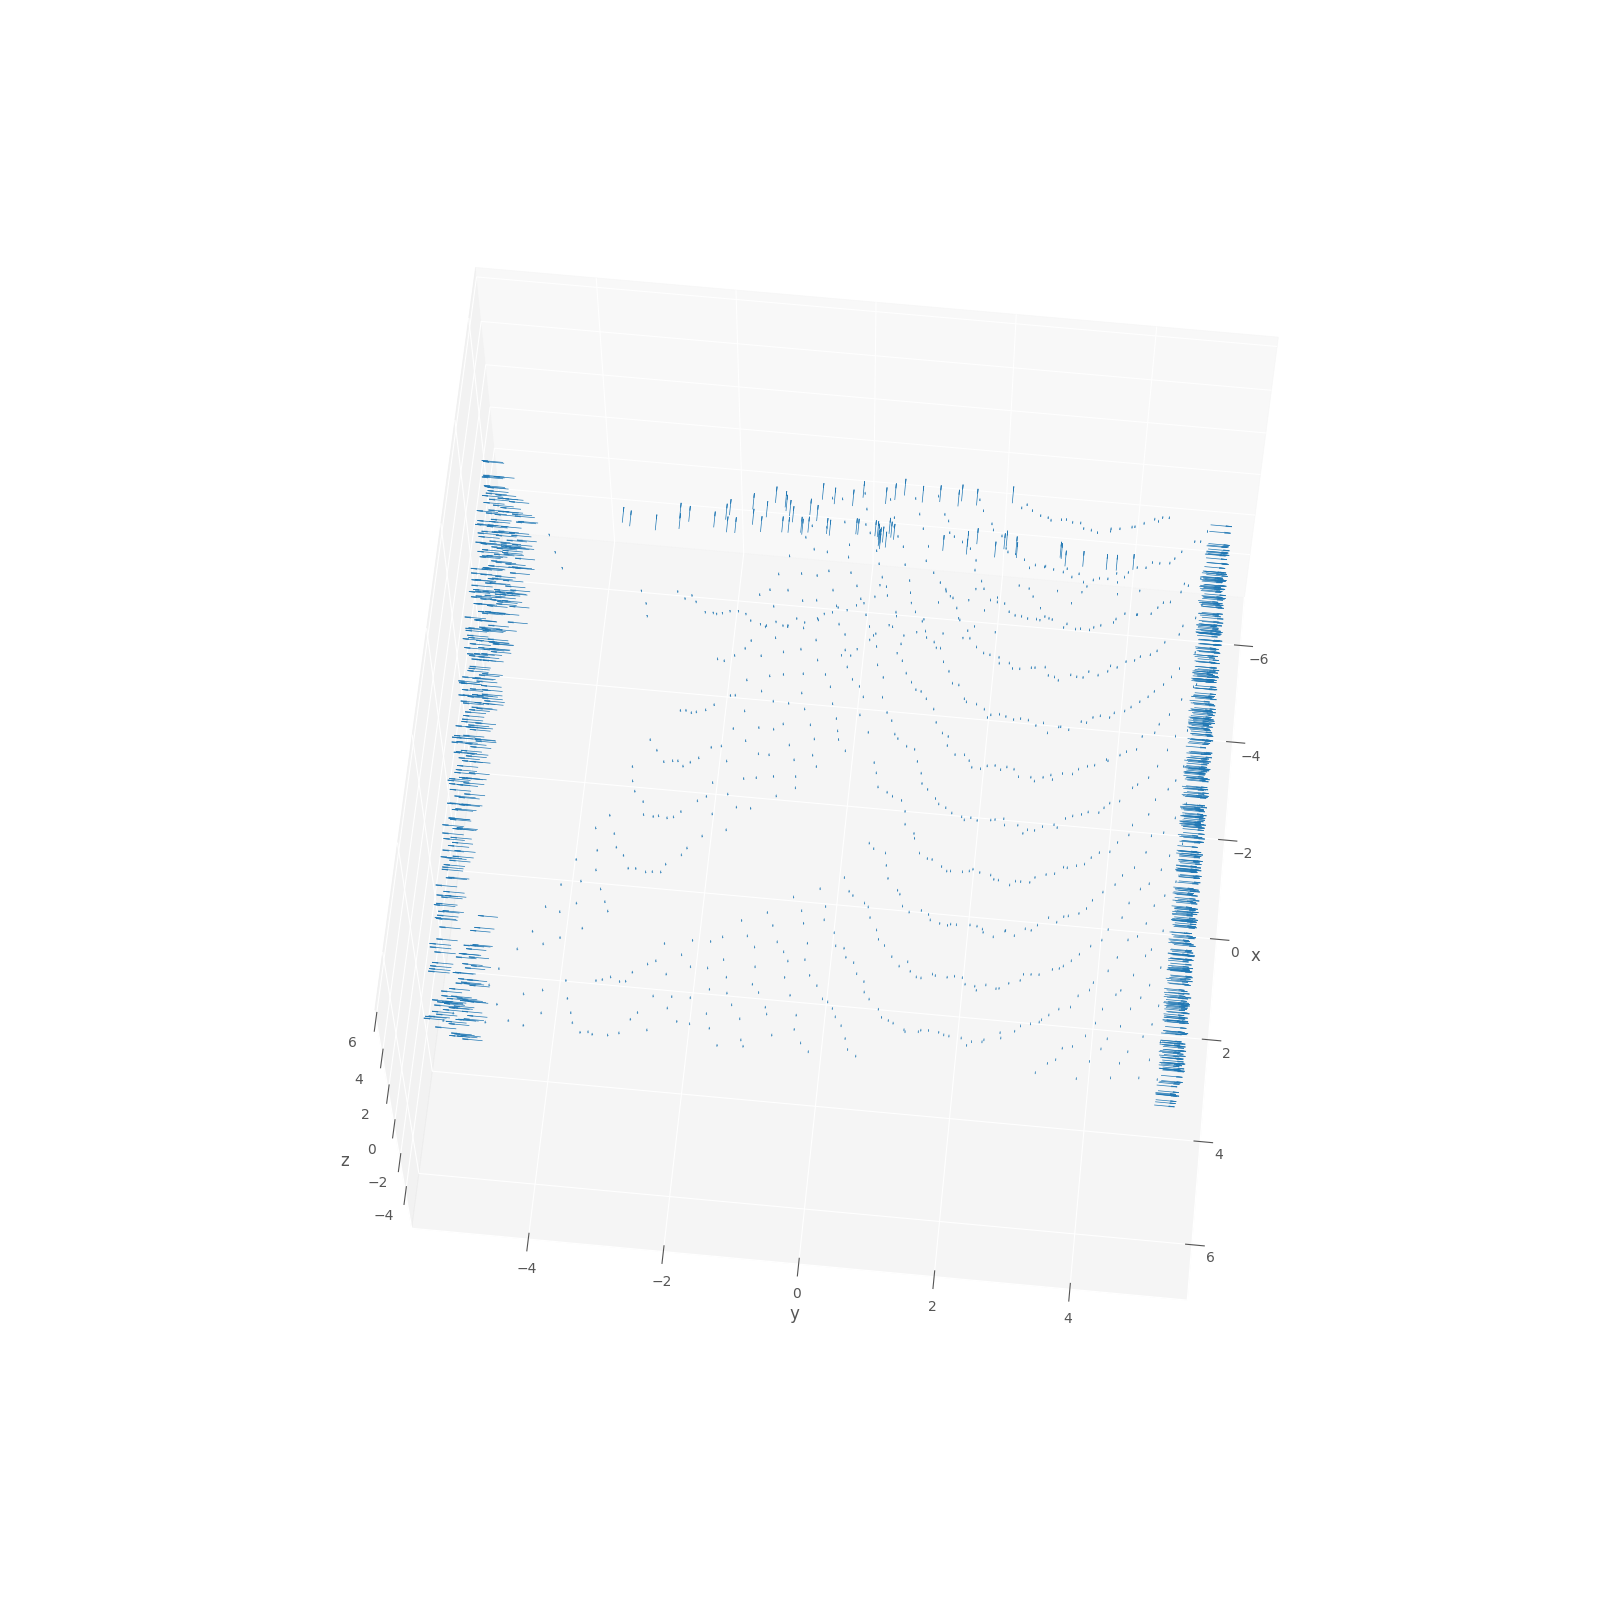

In [5]:
def prepare_3dplot():
    plt.style.use('ggplot')
    plt.rcParams["axes.facecolor"] = 'white'
    fig = plt.figure(figsize=(16, 16))
    axes = fig.gca(projection='3d')
    
    axes.set(xlabel='x', ylabel='y', zlabel='z')
    
    return fig, axes
    
def plot_normal(config, axes, scale=1, orig_name='p', is_normalize=False):
    p = config[orig_name]*scale
    n = config['normal']
    
    axes.quiver(p.x, p.y, p.z, n.x, n.y, n.z, linewidth=0.2, normalize=is_normalize)
    
def plot_intersect(config, axes, dir_names, scale=1, is_normalize=False):
    '''
    plot vector information at intersection.
    '''
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    
    for i, d in enumerate(dir_names):
        point = config['p']*scale
        v = config[d]
#         p = orig if d == 'in' else point
        p = point
        axes.quiver(p.x, p.y, p.z, v.x, v.y, v.z, linewidth=0.5, color=colors[i], normalize=is_normalize, length=0.3)

# ref(plot vector): https://sabopy.com/py/matplotlib_3d_13/
def plot_intersect_with_vector(config, axes, scale=1, sphere=None, is_normalize=False):
    
    # Pass the config to variables
    is_into = config['into']
    is_reflect = config['is_reflect']
    p = config['p'] * scale
    outdir = config['dir']
    n = config['normal']
    indir = config['in']
    in2p = p - indir
    
    # Make the direction data for the arrows
    axes.quiver(p.x, p.y, p.z, n.x, n.y, n.z, linewidth=0.2, normalize=is_normalize)
    
def main():    
    datapath = "../../cube.log"
    with open(datapath, 'r') as log:
        lines = log.readlines()

    in_cnt = 0
    n_in_cnt = 0
    cnt = 0
    fig, axes = prepare_3dplot()
    
    dir_names = ['normal']
    is_normalize = True
    
    times = []
    
    for l in lines:
        config = extract_intersect_config(l)
        if not 'p' in config.keys():
            continue
            
        if cnt % 10 == 0:
            plot_intersect(config, axes, dir_names, is_normalize=is_normalize)
    
        cnt += 1
#     fig, axes = plt.subplots(figsize=[8,8])
#     axes.plot(np.arange(len(times)), times, linewidth=0, marker='o', markersize=0.1)
    plt.show()
            
if __name__ == "__main__":
    main()

In [44]:
normal = float3(0.27228, 0, 0.962218)
v = float3(0, 0, 1)
math.degrees(math.acos(dot(normal, v)))

15.799998638371088

<IPython.core.display.Javascript object>


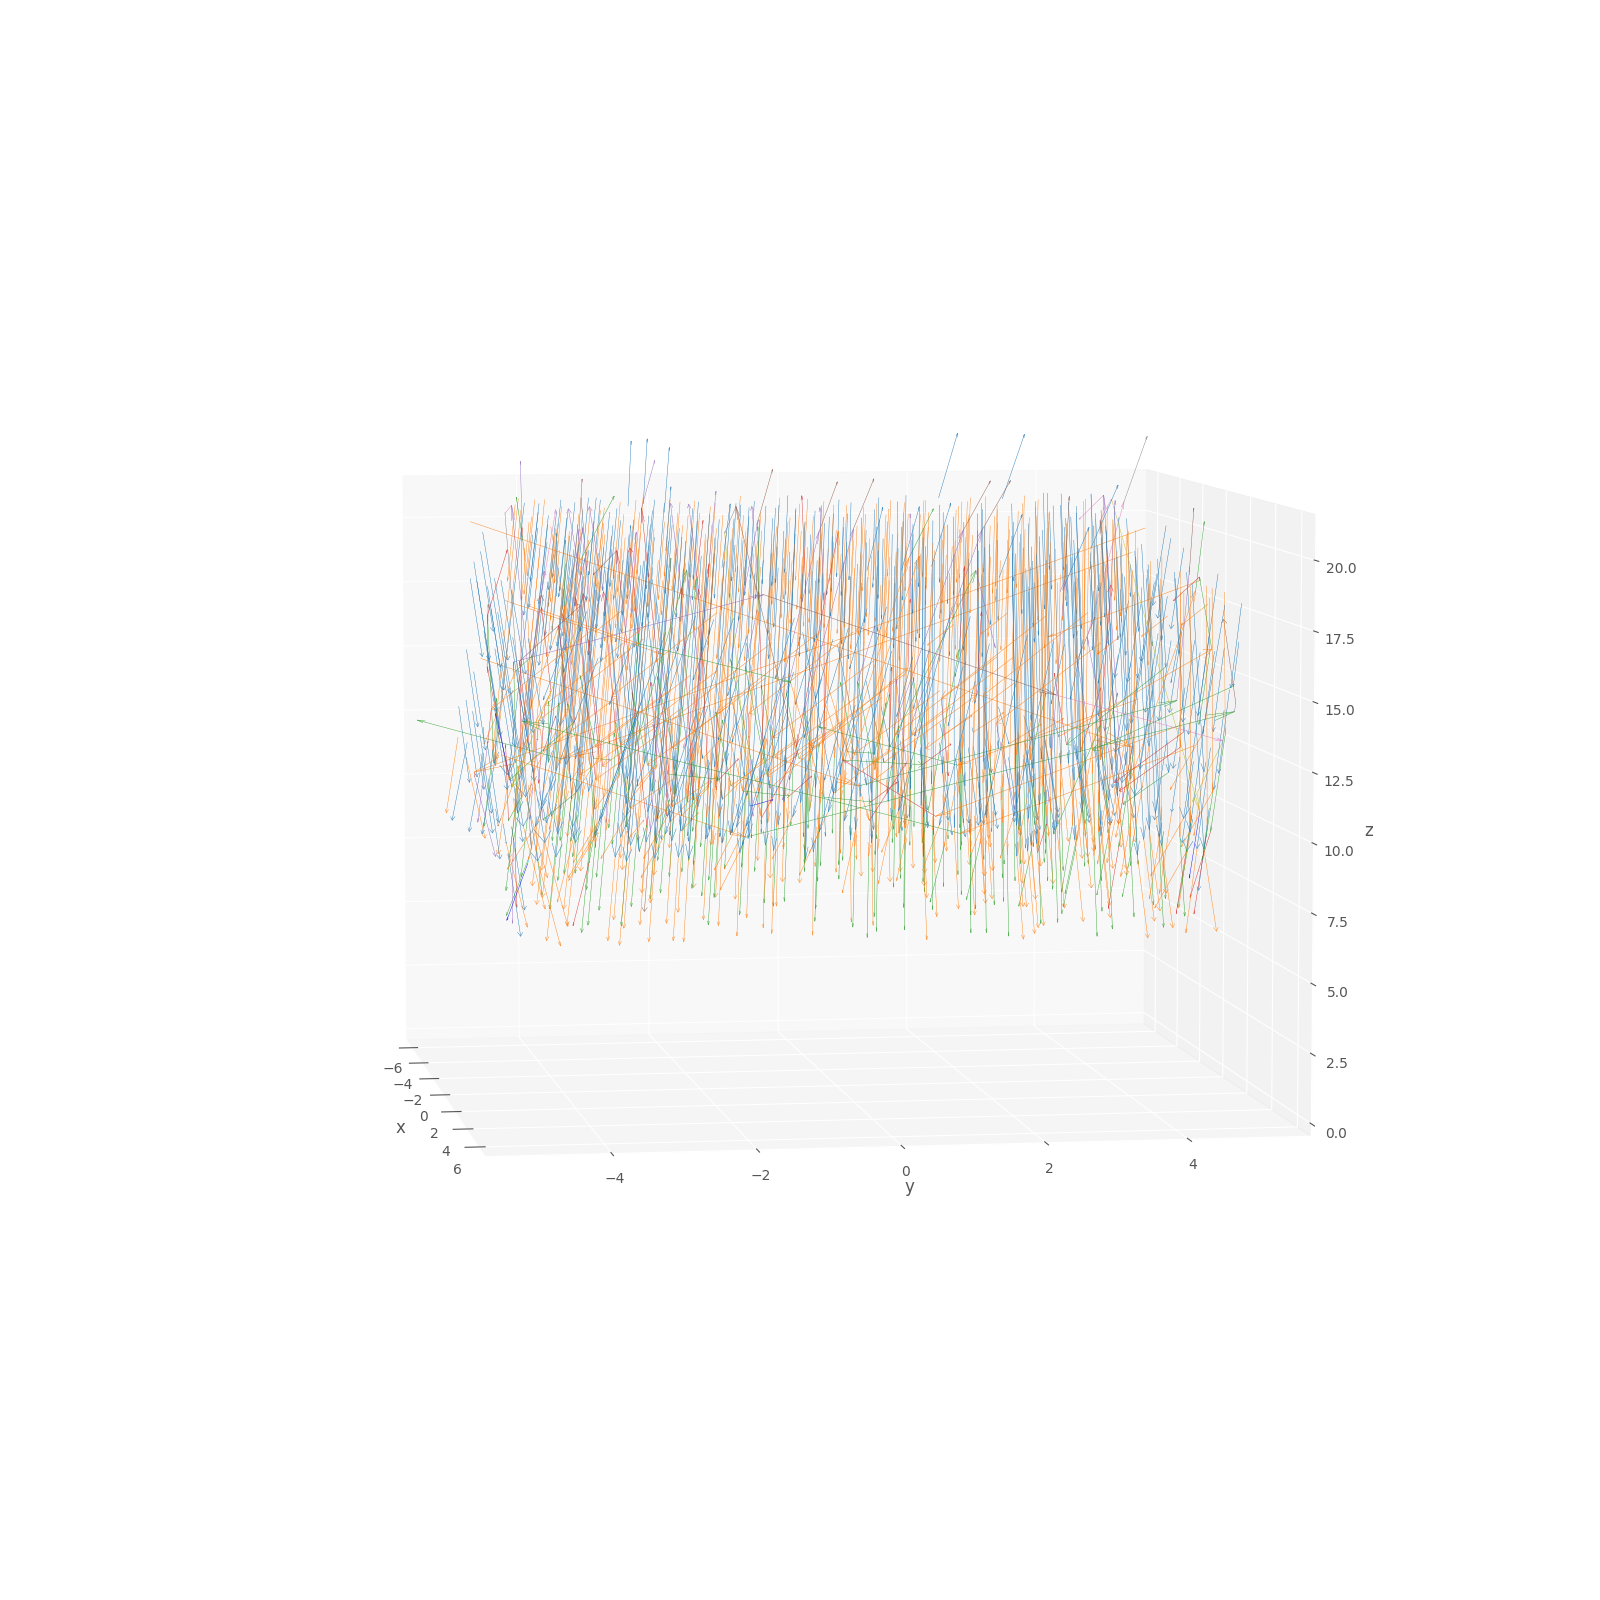

In [66]:
def create_light_pathes(datapath, max_depth):
    light_paths = []

    with open(datapath, mode='r') as log:
        lines = log.readlines()

    current_line = 0
    while current_line < len(lines):
        config = extract_intersect_config(lines[current_line])

        if not 'depth' in config.keys() or config['depth'] == max_depth:
            current_line += 1
            continue

        lpath = []

        if config['depth'] == max_depth-1:
            lpath.append(config)
            while True:
                current_line += 1
                if current_line >= len(lines):
                    break

                config = extract_intersect_config(lines[current_line])
                if 'depth' in config.keys() and config['depth'] < max_depth:
                    lpath.append(config)
                else:
                    break
        light_paths.append(lpath)
    return light_paths

def main():
    datapath = '../../cube.log'
    max_depth = 12
    light_pathes = create_light_pathes(datapath, max_depth)
    
    fig, axes = prepare_3dplot()
    
    path_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                   'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
                   'b', 'g']
    
    for j, lp in enumerate(light_pathes):
        if j%10 != 0:
            continue
        for i in range(len(lp)):
            ro = lp[i]['p']
            if i == len(lp)-1:
                v = lp[i]['dir']
                axes.quiver(ro.x, ro.y, ro.z, v.x, v.y, v.z, 
                            color=path_colors[i], normalize=False, linewidth=0.3,
                            length=3,arrow_length_ratio=0.05)
            else:
                o2next = lp[i+1]['p'] - ro
                axes.quiver(ro.x, ro.y, ro.z, o2next.x, o2next.y, o2next.z,
                            color=path_colors[i], normalize=False, linewidth=0.3,
                            arrow_length_ratio=0.05)

if __name__ == "__main__":
    main()